## Agenda

- Implement a **kmeans** algorithm
- Decide how many **clusters** we should consider in kmeans

As main data we are going to use the returns of 2,000 hedge fund managers over 50 months. The data are from James et al. "An Introduction to Statistical Learning: 2nd ed." (2021). 

In [1]:
#Import pandas to deal with the dataset
import pandas as pd

#Import the data on hedge fund performance
df = pd.read_csv(r'Fund.csv', index_col = 0)

Before moving to the actual implementation we can check if the dataset contains any missing value, as this will ultimately affect the clustering algorithm. 

In [2]:
df.isnull().sum()

Manager1       0
Manager2       0
Manager3       0
Manager4       0
Manager5       0
              ..
Manager1996    0
Manager1997    0
Manager1998    0
Manager1999    0
Manager2000    0
Length: 2000, dtype: int64

There is no missing data in this dataset, so now we can proceed with pre-processing the data. As usual, we need to rescale the data first, so that each record of fund performance has mean equal to 0 and variance equal to 1

In [3]:
#Standardise the fund returns so that they are all
#on the same scale
from sklearn.preprocessing import StandardScaler

# Calculate the average fund performance over the sample period 
avg_perf = df.mean(axis = 0)

# create a dataframe with avg return of every fund
X = pd.DataFrame(avg_perf, index = df.columns)

# Implement the rescaling to the avg return
X = StandardScaler().fit_transform(X)

### K-means clustering

We can then now estimate the clusters using the k-means algorithm. The **k-means** function takes as an input the number of clusters. To make the computation process more efficient, we can simply estimate the clusters through a **for** loop in which we "loop over" all different options in terms of number of clusters. Clusters are calculated by looking at the average fund performance. 

In [4]:
# Find the appropriate cluster number
from sklearn.cluster import KMeans

# initialise an empty list
wcss = []

# run the kmeans for 20 clusters
# n_clusters: the num of clusters to try
# init: how to initialise the search, e.g. which data to use.
# when using k-means++ we try a smart approach provided
# max_iter: num of iterations to find the solution
# n_init: num of time the k-means algorithm will be run with different centroid seeds
# random_stateL determines random num generation for centroid initialization
# inertia: sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(X)
    wcss.append([i,kmeans.inertia_])

elbow = pd.DataFrame(wcss, columns =['k','wcss']).set_index('k')

Above we simply calculated the clusters assuming $k=1,...,20$. We can now plot a so-called "elbow" plot in which we report the within-cluster variation vs the number of clusters. 

<AxesSubplot:xlabel='k', ylabel='wcss'>

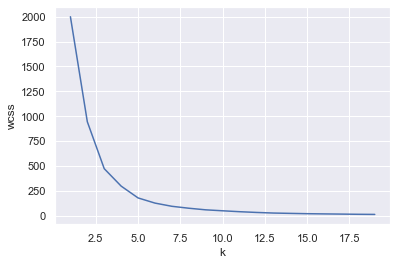

In [5]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Plot the within-cluster variation as a function of the clusters
sns.lineplot(x="k", y="wcss", data=elbow)

It seems from the Elbow plot that the marginal increase from an additional cluster drops around the $k=5$ specification. We can create a dataframe with a smaller number of clusters, say for e.g., $k=3$ and check for clusters composition if we notice any insight. 

In [6]:
# Fitting K-Means to the dataset
kmeans    = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans  = kmeans.fit_predict(X)

# Beginning of the cluster numbering with 1 instead of 0
y_kmeans  = y_kmeans + 1

# New Dataframe called cluster
cluster   = pd.DataFrame(y_kmeans, columns = ['cluster'])
cluster['performance'] = X

To have a sense of the meaning of the clusters we can look at the average performance per cluster. This often falls under the heading of "ex-post" heuristic interpretation. 

In [7]:
kmeans_mean_cluster = pd.DataFrame(round(cluster.groupby('cluster').mean(),2)).sort_values(by='performance',axis=0)
print(kmeans_mean_cluster)

         performance
cluster             
4              -2.19
1              -0.82
2               0.01
3               0.85
5               2.20


It seems that cluster 4 and 5 represents the worst and top performing funds, on average. One can try to see what happens by increasing the number of clusters, by setting **n\_clusters** greater than 5. 